In [60]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
df = pd.read_csv('data/show_no_show_ready_to_model.csv')

In [62]:
df

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,Gender_M,AppointmentDay_DOW,AppointmentDay_Day_number,AppointmentDay_month,Difference_Days_App_Date_and_Sched_Day
0,62,0,1,0,0,0,0,0,0,0,29,0,0
1,56,0,0,0,0,0,0,0,1,0,29,0,0
2,62,0,0,0,0,0,0,0,0,0,29,0,0
3,8,0,0,0,0,0,0,0,0,0,29,0,0
4,56,0,1,1,0,0,0,0,0,0,29,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106485,56,0,0,0,0,0,1,0,0,4,7,1,34
106486,51,0,0,0,0,0,1,0,0,4,7,1,34
106487,21,0,0,0,0,0,1,0,0,4,7,1,40
106488,38,0,0,0,0,0,1,0,0,4,7,1,40


In [63]:
X = df.drop('No-show',axis=1,inplace=False)
y = df['No-show']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=69)

In [64]:
RandomForestClassifier().fit(X_train,y_train).score(X_train, y_train)

0.9486320569602512

In [65]:
RandomForestClassifier().fit(X_train,y_train).score(X_test, y_test)

0.7610551476865289

## STRONG OVERFITTING 94% TRAIN VS 76% on TEST, our model isn't generalizing well enough

In [66]:
model = RandomForestClassifier()
params_random = {
    'n_estimators': [300,320,350,375,400],
    'max_depth':[x for x in range(5,15)],
    'min_samples_split':[3,4,5],
    'min_samples_leaf' : [1,2,4]
}

In [67]:
model_sel = RandomizedSearchCV(model, params_random)

In [68]:
model_sel.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12,
                                                      13, 14],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [3, 4, 5],
                                        'n_estimators': [300, 320, 350, 375,
                                                         400]})

In [69]:
model_sel.best_params_

{'n_estimators': 320,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_depth': 13}

In [70]:
model_sel.best_estimator_

RandomForestClassifier(max_depth=13, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=320)

In [71]:
model_sel.best_estimator_.score(X_test, y_test)

0.7979625519321609

In [72]:
model_sel.best_estimator_.score(X_train, y_train)

0.8043813421539496

## SELECT KBEST FEATURES

In [73]:
from imblearn.under_sampling import InstanceHardnessThreshold
from collections import Counter
from sklearn.datasets import load_digits

In [74]:
iht = InstanceHardnessThreshold(random_state=42)

X = df.drop('No-show',axis=1,inplace=False)
y = df['No-show']

X_res, y_res = iht.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.33, random_state=69)

Resampled dataset shape Counter({0: 21604, 1: 21559})


In [75]:
model_sel = RandomizedSearchCV(model, params_random)
model_sel.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12,
                                                      13, 14],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [3, 4, 5],
                                        'n_estimators': [300, 320, 350, 375,
                                                         400]})

In [76]:
model_sel.best_params_

{'n_estimators': 375,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 14}

In [77]:
model_sel.best_estimator_

RandomForestClassifier(max_depth=14, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=375)

In [78]:
model_sel.best_estimator_.score(X_test, y_test)

0.9205981465880371

In [79]:
model_sel.best_estimator_.score(X_train, y_train)

0.9253086206300356

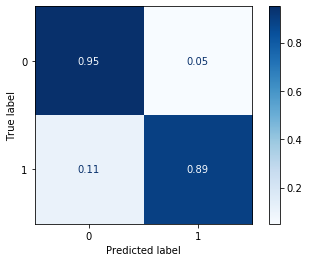

In [80]:
predictions = model_sel.predict(X_test)

# Generate confusion matrix
matrix = plot_confusion_matrix(model_sel, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

## Now that we know a good range, instead of RandomizedSearch we will use Grid

In [83]:
params_grid = {
    'n_estimators': [300,290,315,350],
    'max_depth':[x for x in range(13,17)],
    'min_samples_split':[3,4,5],
    'min_samples_leaf' : [1,2]
}
gs_model = GridSearchCV(model, params_grid)

gs_model.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [13, 14, 15, 16],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [300, 290, 315, 350]})

In [84]:
model_sel.best_params_

{'n_estimators': 375,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 14}

In [85]:
model_sel.best_estimator_

RandomForestClassifier(max_depth=14, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=375)

In [86]:
model_sel.best_estimator_.score(X_test, y_test)

0.9205981465880371

In [87]:
model_sel.best_estimator_.score(X_train, y_train)

0.9253086206300356

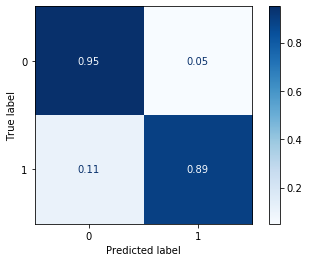

In [88]:
predictions = model_sel.predict(X_test)

# Generate confusion matrix
matrix = plot_confusion_matrix(model_sel, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

In [89]:
df2 = pd.DataFrame([model_sel.best_estimator_.feature_importances_],columns=X_train.columns)

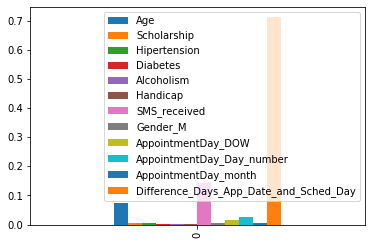

In [90]:
df2.plot.bar()